Se procede a importar todas las librerías que serán necesarias para realizar el trabajo con redes neuronales y realizar el modelo de regresión lineal.

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


Se importa el dataset, que está guardado como un archivo xls (archivo de excel con compatibilidad).

In [2]:
raw_dataset = pd.read_excel("concrete_data.xls")

Se genera una copia del dataset para ser utilizada en caso de ser necesario, así mismo se muestran las últimas instancias del dataset para confirmar que los datos están siendo separados de buena manera.

In [3]:
dataset = raw_dataset.copy()
dataset.tail()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.401235


Se verifica si existe alguna instancia con datos nulos o fuera del contexto.

In [4]:
dataset.isna().sum()

Cement                           0
Blast Furnace Slag               0
Fly Ash                          0
Water                            0
Superplasticizer                 0
Coarse Aggregate                 0
Fine Aggregate                   0
Age                              0
Concrete compressive strength    0
dtype: int64

Se obtiene el análisis descriptivo de las variables involucradas en el dataset, de esta manera se podrá realizar la normalización de los datos, ya que se utilizará la media y la desviación de cada variable.

In [5]:
dataset.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


Se obtiene la información necesaria para saber que se está trabajando con datos numérico, debido a la naturaleza matemática del cálculo necesario para que la red genere el modelo de regresión.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Cement                         1030 non-null   float64
 1   Blast Furnace Slag             1030 non-null   float64
 2   Fly Ash                        1030 non-null   float64
 3   Water                          1030 non-null   float64
 4   Superplasticizer               1030 non-null   float64
 5   Coarse Aggregate               1030 non-null   float64
 6   Fine Aggregate                 1030 non-null   float64
 7   Age                            1030 non-null   int64  
 8   Concrete compressive strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Se eliminan las columnas "Blast Furnace Slag", "Fly Ash", "Superplasticizer", "Age", ya que se derivado del análisis de sus medias y desviaciones estándar, se concluye que pueden afectar en el desempeño del modelo.

In [7]:
# dataset = dataset.drop(["Age"], axis=1)

De divide el dataset en una proporción de 80%-20% con un el 80% formando parte del dataset de entrenamiento y el 20% restante para el dataset de prueba.

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Se grafica de manera cruzada los componenetes que se consideran importantes en la mezcla para generar la mayor dureza del concreto, para obtener así de manera visual una posible correlación entre ellas.

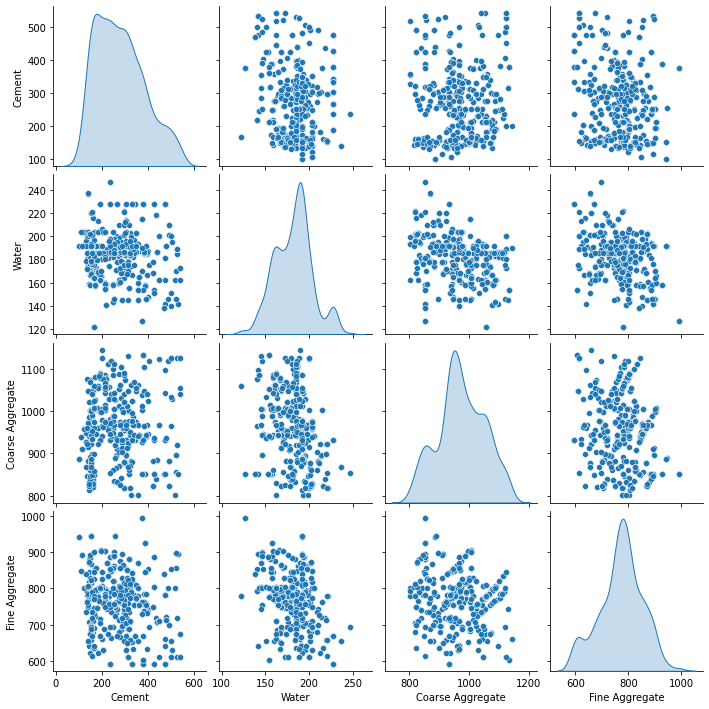

In [9]:
sns.pairplot(train_dataset[["Cement", "Water", "Coarse Aggregate", "Fine Aggregate"]], diag_kind="kde")

Se obtienen las datos estadísticos de cada una de las variables del dataset, quitando la variable que se busca calcular del dataset de entrenamiento.

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("Concrete compressive strength")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cement,824.0,280.270971,104.483845,102.00,193.125,266.00,350.000,540.0
Blast Furnace Slag,824.0,73.170910,85.865408,0.00,0.000,22.00,142.500,359.4
Fly Ash,824.0,55.317124,64.097588,0.00,0.000,0.00,118.270,200.1
Water,824.0,182.029053,21.288882,121.75,164.900,185.70,192.000,247.0
Superplasticizer,824.0,6.146244,6.000398,0.00,0.000,6.10,10.115,32.2
Coarse Aggregate,824.0,973.990789,77.755716,801.00,932.000,968.00,1030.250,1145.0
Fine Aggregate,824.0,771.896408,80.030794,594.00,721.750,779.32,824.000,992.6
Age,824.0,45.708738,63.603343,1.00,7.000,28.00,56.000,365.0


Se obtienen los valores de la variable que se busca obtener mediante la regresión.

In [11]:
train_labels = train_dataset.pop("Concrete compressive strength")
test_labels = test_dataset.pop("Concrete compressive strength")

Se normalizan los datos, para poder pasarlos através de la red.

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Se crea el modelo, a utilizarse, el cual consta de 5 capas, 1 capa de entrada con 8 neuronas, 3 capas intermedias densamente conectadas, y una capa de salida(característico de los modelos de regresión), cada neurona cuenta con una función de activación relu.

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
                
  return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


Se usa de manera prelimiar el modelo para saber que tanto la información normalizada como el modelo funcionan correctamente.

In [16]:
example_batch = normed_train_data[:10]
example_batch = model.predict(example_batch)
example_batch

1/1 [==============================] - 0s 204ms/step


array([[-0.21159542],
       [-0.59354085],
       [-1.6034813 ],
       [-0.2738086 ],
       [-1.1325185 ],
       [-1.4321802 ],
       [-0.82985574],
       [-0.92005396],
       [-0.29059944],
       [-0.03344815]], dtype=float32)

Se entrena el modelo, con un total de 1000 épocas, aunque hay que remarcar que para encontrar un desempeño optimo según los datos, se tuvieron que hacer 4 iteraciones de entrenamiento.

In [36]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Se obtiene la información propia de los valores de perdida así como de los errores en el modelo.

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,21.348251,3.453300,21.348251,40.006706,4.526361,40.006706,995
996,21.373451,3.477621,21.373451,39.993771,4.426894,39.993771,996
997,21.597727,3.455980,21.597727,39.882481,4.493650,39.882481,997
998,21.328045,3.423547,21.328045,39.486546,4.439372,39.486546,998
999,21.500767,3.454397,21.500767,39.261303,4.402368,39.261303,999


Se grafica la información de la perdida y los errores del modelo. Hay que remarcar que la gráfica representa el resultado de la 4ta. iteración.

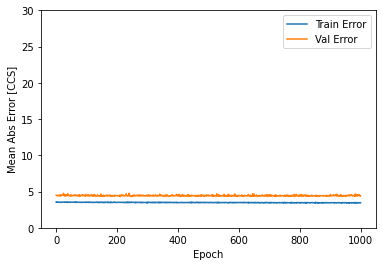

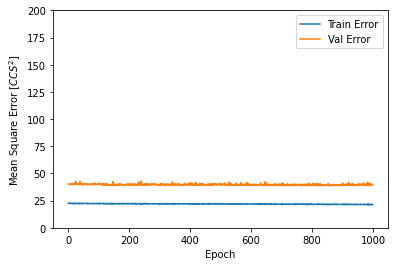

In [38]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [CCS]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$CCS^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,200])
  plt.legend()
  plt.show()


plot_history(history)

Se muestran los resultados de la evaluación del modelo.

In [81]:

resultados = model.evaluate(normed_test_data, test_labels, batch_size=128)

print("Perdida de la prueba, Presición de la prueba:", resultados)

2/2 [==============================] - 0s 2ms/step - loss: 45.7270 - mae: 4.5741 - mse: 45.7270
Perdida de la prueba, Presición de la prueba: [45.72700881958008, 4.574117183685303, 45.72700881958008]


Se realizan predicciones de prueba para comprobar sobre los posibles resultados que se podrían obtener del modelo.

7/7 [==============================] - 0s 1ms/step


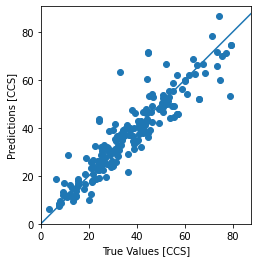

In [40]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Valores reales [CCS]')
plt.ylabel('Predicciones [CCS]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Se grafica la distribución del error entre la predicciones hechas por el modelo en el paso anterior, teniendo la districión que nos permitirá saber que tan dispersos están los datos de error.

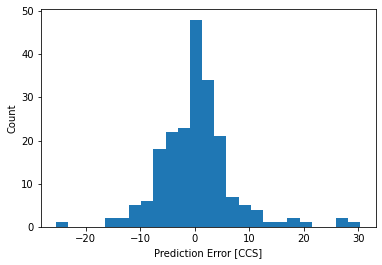

In [41]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción [CCS]")
_ = plt.ylabel("Valor")

Se importan los datos del archivo para realizar el modelo sobre un método no basado en redes neuronales.

In [43]:
data_train = pd.read_excel("concrete_data.xls")

Se analiza si los datos fueron cargados de manera correcta, verificando si son el número de filas y columnos correctos.

In [44]:
data_train.shape

(1030, 9)

Se obtienen los últimos datos del dataset, para verificar que los datos se estén leyendo de la mejor manera posible.

In [46]:
data_train.tail()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.401235


Se obtiene un análisis descriptivo de los datos.

In [47]:
data_train.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [48]:
data_train.dtypes

Cement                           float64
Blast Furnace Slag               float64
Fly Ash                          float64
Water                            float64
Superplasticizer                 float64
Coarse Aggregate                 float64
Fine Aggregate                   float64
Age                                int64
Concrete compressive strength    float64
dtype: object

Se grafica en forma de cajas para verificar si los datos cuentan con la forma necesaria para ser analizados mediante el modelo de regresión. Además de que es información que puede servir para realizar conclusión acerca de los modelos.

<AxesSubplot:>

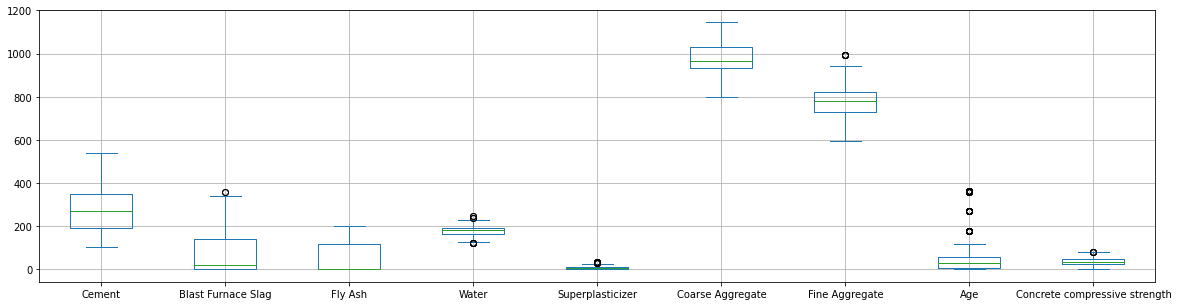

In [50]:
data_train.plot.box(figsize=(20,5),grid=True)

Se separa la información en datos de entrenamiento y datos de prueba.

In [57]:
y_data = data_train['Concrete compressive strength']
x_data = data_train.drop(columns=['Concrete compressive strength'])

Al igual que en modelo con redes, se reescalan los datos, debido a que el modelo de regresión seleccionado necesita ese reescalado.

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaler = scaler.fit_transform(x_data)
x_data

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


Se grafica de manera cruzada todas las variables del dataset, buscando con ello poder obtener información relevante, para el análisis.

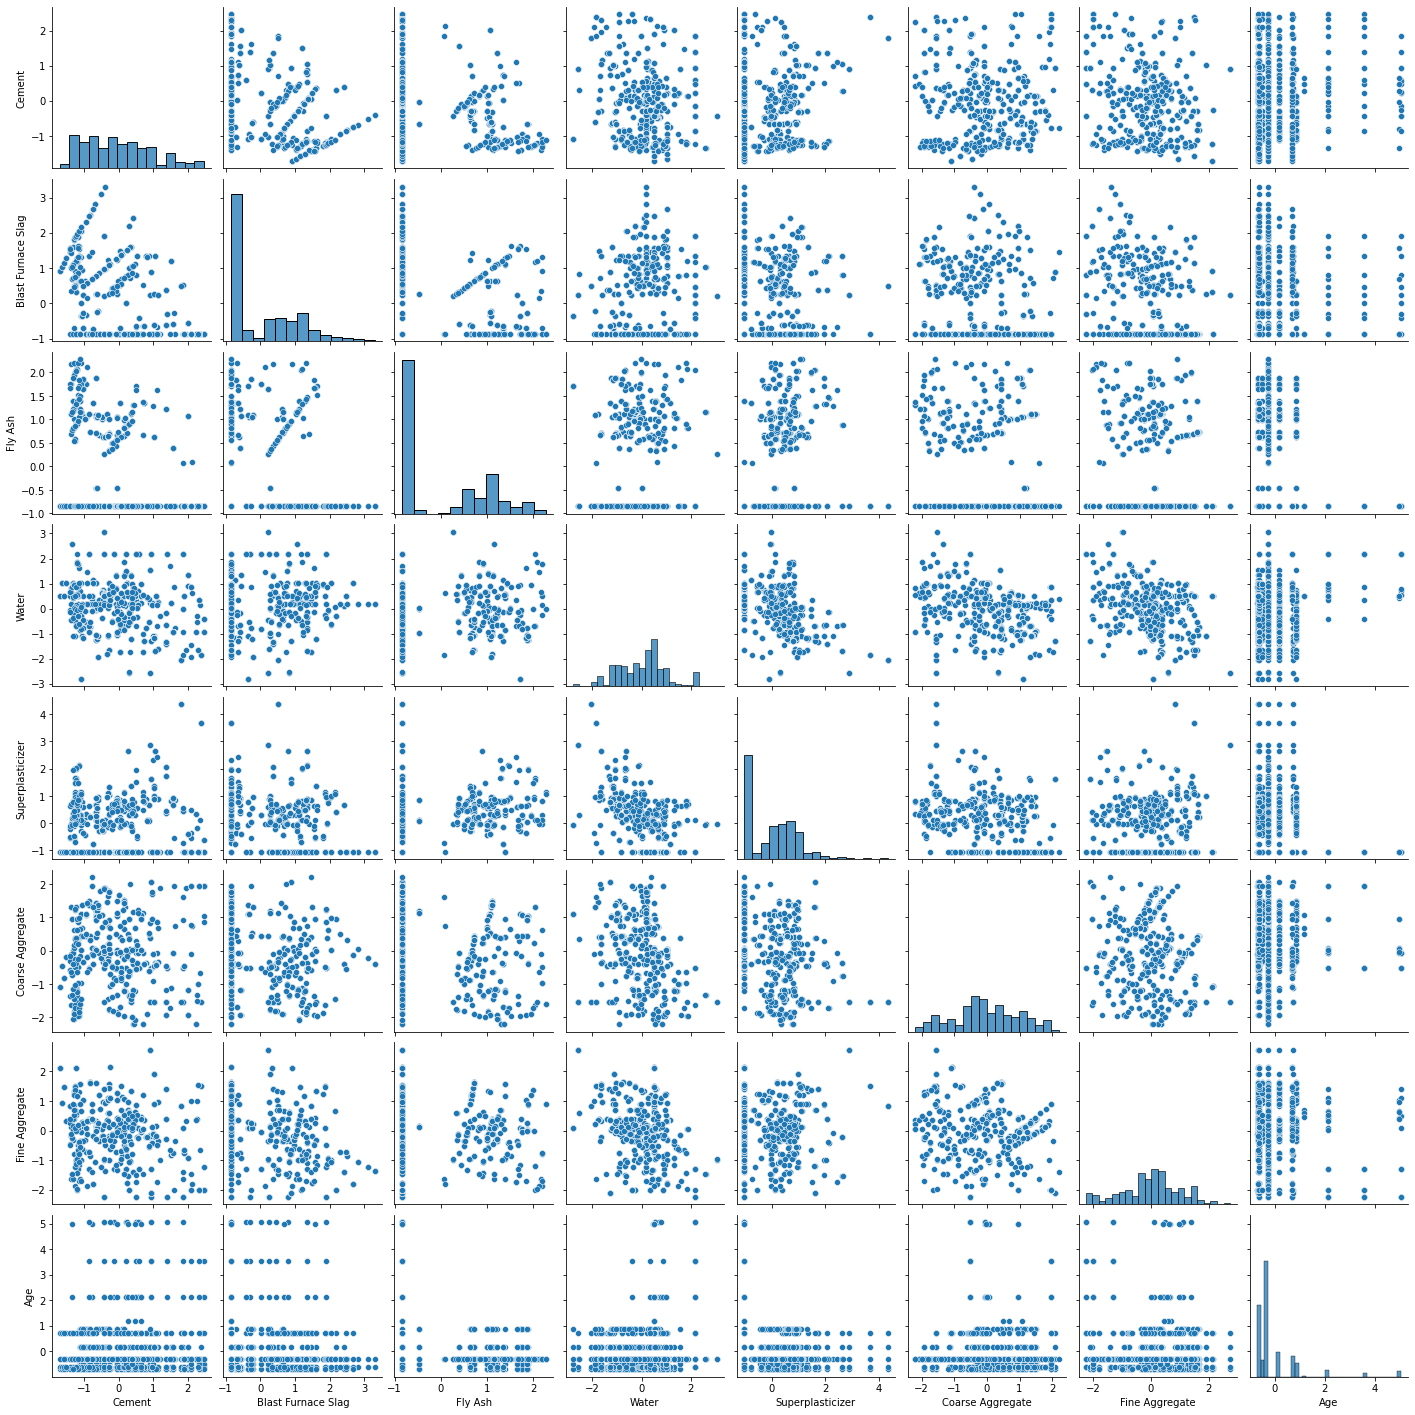

In [59]:
sns.pairplot(pd.DataFrame(x_scaler,columns=x_data.columns))

Se importa el modelo de regresión, en este caso, RandomForestRegressor, de igual manera se configura para que tenga una profundida de 5 capas.

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
regressor = RandomForestRegressor(max_depth=5, min_samples_split=3)

Se seperan los datos en datos para los ejes x y datos para los ejes y, tanto datos de entrenamiento como datos de prueba.

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaler, y_data, test_size=0.20, random_state=1, shuffle=True)

Se entrena el modelo.

In [66]:
regressor.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_split=3)

Se obtiene una muestra de los datos predichos por el modelo.

In [67]:
y_pred = regressor.predict(x_test)

array([20.87926007, 14.16036162, 26.29962413, 13.36806504, 30.63763837,
       51.47354411, 17.49208959, 43.01957308, 41.69264413, 14.63425807,
       40.41998472, 13.36373245, 40.93490769, 29.29392534, 14.01348858,
       30.01823563, 43.26018442, 49.3733358 , 50.77841191, 31.96728669,
       26.44942994, 47.92351947, 16.27203565, 59.06557952, 62.43966549,
       37.42020934, 34.9736417 , 31.33684266, 35.47226349, 13.69746144,
       43.54462925, 57.74889252, 32.61791068, 18.87588977, 36.27871316,
       36.79428349, 13.75777875, 31.18889438, 26.58918638, 13.07865379,
       32.95749972, 15.58930141, 46.07146821, 37.48335369, 31.61607357,
       28.27707932, 35.65613818, 26.33007601, 33.87997683, 48.23410665,
       29.05671425, 34.29270419, 56.05208013, 50.28567016, 61.46492022,
       13.0934814 , 31.24115381, 26.45985815, 34.21944514, 45.96535279,
       43.57103756, 43.80912105, 46.19090694, 42.78083977, 25.45762256,
       31.23332894, 54.64465468, 36.96100697, 48.67087292, 27.54

Se grafican los datos predichos contra los datos reales, para obtener una referencia de que tan confiable es el modelo.

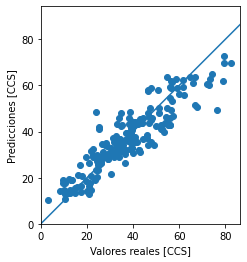

In [72]:
plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales [CCS]')
plt.ylabel('Predicciones [CCS]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Se obtiene el valor de estimador R cuadrado.

In [75]:
r2 = regressor.score(x_train, y_train)

In [76]:
r2

0.8815364104988725

Se obtiene la distribución de los valores del error de predicción.

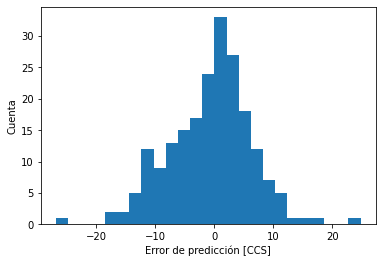

In [78]:
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción [CCS]")
_ = plt.ylabel("Valor")

In [28]:
import numpy as np

Se importan los datos del dataset cifar10 para la generación del modelo de clasificación con redes neuronales

In [298]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Se crean las clases que se usaran para la clasificación

In [299]:
clases_rn = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Se verifica que los datos se hayan importado correctamente

In [300]:
print(x_train.shape)
print(len(y_train))
print(x_test.shape)
print(len(y_test))

(50000, 32, 32, 3)
50000
(10000, 32, 32, 3)
10000


In [301]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Se normalizan los datos para poder trabajar con redes neuronales.

In [302]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Se verifica que la normalización sea adecuada graficando una imagen del conjunto de datos de entrenamiento.

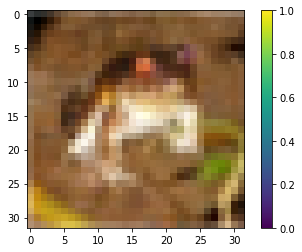

In [303]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

De igual manera, se confirma que el resto de los datos del dataset de entrenamiento, estén etiquetados de manera correcta, graficando algunos de ellos.

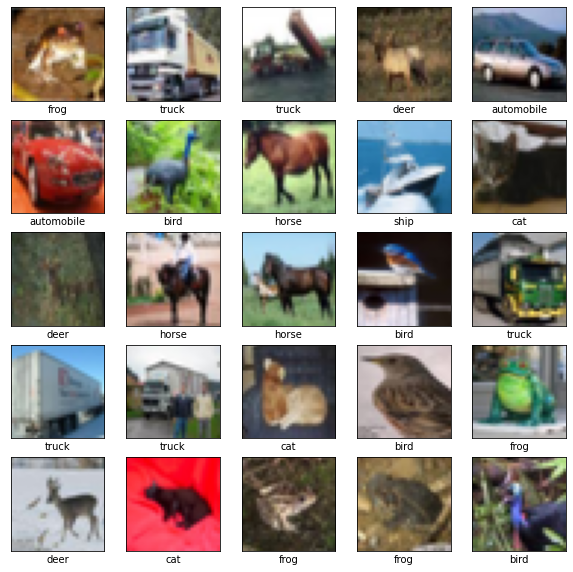

In [304]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(clases_rn[y_train[i][0]])
plt.show()

Se genera el modelo, creando la composición mediante 7 capas, de las cuales se utilizan neuronas convolucionales, mendiante función de activación relu, una capa de neuronas planas con la misma función de activación, una capa con una de salida densamente conectada con la cantidad necesaria de salidas para cada clase, con función de activación softmax.

In [305]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
])

Se utiliza el optimizador RMSprop, como optimizador del modelo.

In [306]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

Se compila el modelo y se muestran los parámetros, para verificar su correcta compilación.

In [307]:
model.compile(optimizer= optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_30 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 activation_31 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 15, 15, 32)        0         
                                                      

Se entrena el modelo en un proceso de 10 épocas, tienendo como resultado despues de una iteración una precisión de 66% aprox.

In [308]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 73s 46ms/step - loss: 1.8267 - accuracy: 0.3272
Epoch 2/10
1563/1563 [==============================] - 74s 47ms/step - loss: 1.5132 - accuracy: 0.4529
Epoch 3/10
1563/1563 [==============================] - 74s 47ms/step - loss: 1.3850 - accuracy: 0.5023
Epoch 4/10
1563/1563 [==============================] - 75s 48ms/step - loss: 1.2879 - accuracy: 0.5403
Epoch 5/10
1563/1563 [==============================] - 74s 47ms/step - loss: 1.2073 - accuracy: 0.5702
Epoch 6/10
1563/1563 [==============================] - 75s 48ms/step - loss: 1.1414 - accuracy: 0.5965
Epoch 7/10
1563/1563 [==============================] - 74s 47ms/step - loss: 1.0858 - accuracy: 0.6153
Epoch 8/10
1563/1563 [==============================] - 74s 47ms/step - loss: 1.0348 - accuracy: 0.6382
Epoch 9/10
1563/1563 [==============================] - 74s 47ms/step - loss: 0.9989 - accuracy: 0.6500
Epoch 10/10
1563/1563 [==============================] - 75s 48m

In [309]:
test_loss, test_acc = model.evaluate(x_train,  y_train, verbose=2)
print('\nTest accuracy:', test_acc)

1563/1563 - 14s - loss: 0.8344 - accuracy: 0.7085 - 14s/epoch - 9ms/step

Test accuracy: 0.7084599733352661


Se realizan pruebas sobre la data del dataset de prueba.

In [310]:
predictions = model.predict(x_test)

313/313 [==============================] - 3s 9ms/step


Se evalúa una de las predicciones realizadas, para comprobar de manera preeliminar los resultados.

In [311]:
predictions[0]

array([1.1517918e-02, 1.9293196e-04, 1.1090875e-02, 6.6567117e-01,
       4.1655665e-03, 2.6913211e-01, 1.8437322e-02, 3.6028612e-03,
       1.4958855e-02, 1.2304005e-03], dtype=float32)

In [312]:
np.argmax(predictions[0])

3

Se corrobora que el dato predicho coincide con el dato de prueba.

In [313]:
y_test[0]

array([3], dtype=uint8)

Se generan las funciones que permitirán comprobar los resultados del modelo.

In [314]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(np.array(clases_rn)[predicted_label.astype('int')],
                                100*np.max(predictions_array),
                                np.array(clases_rn)[true_label.astype('int')]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i][0]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)


  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Se comprueba sobre una imagen los resultados de la predicción.

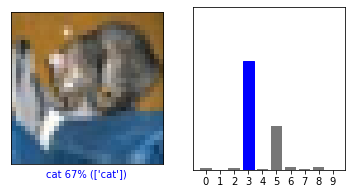

In [315]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], y_test)
plt.show()

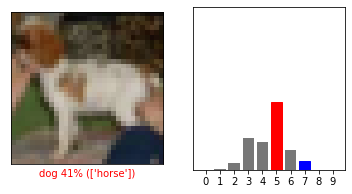

In [316]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_train, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_train)
plt.show()

Se verifica sobre varias imágenes los resultados de las predicciones realizadas por el modelo. Pudiendo comprobar que modelo tiene un desempeño aceptable para haber sido entrenado en una sóla iteración.

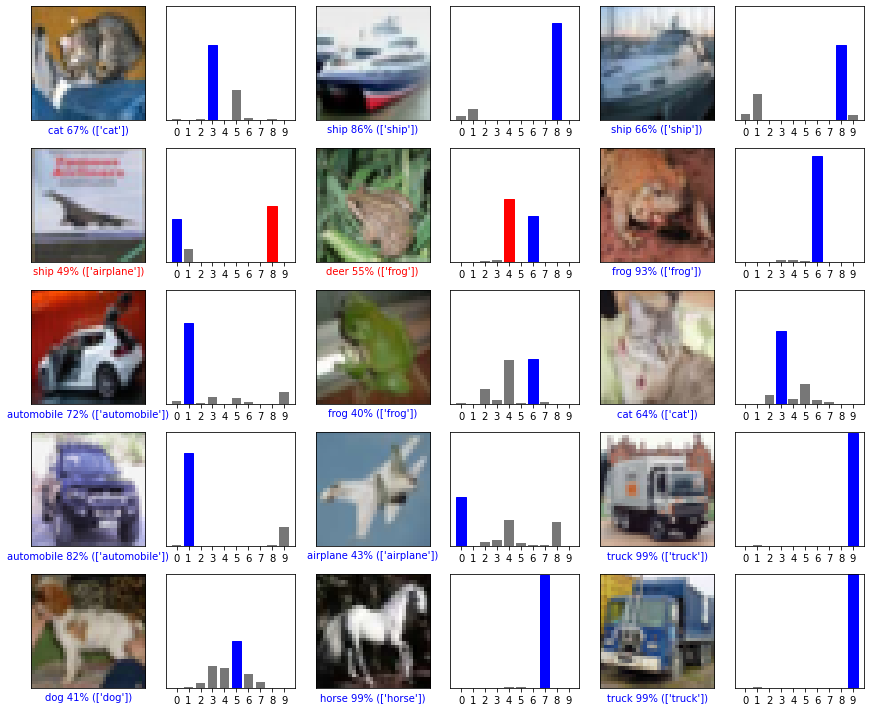

In [317]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

Se importan los datos del dataset para generar el modelo mediante el método KNN

In [320]:
cifar10knn = tf.keras.datasets.cifar10
(x_trainknn, y_trainknn), (x_testknn, y_testknn) = cifar10knn.load_data()
print(x_trainknn.shape)
print(len(y_trainknn))
print(x_testknn.shape)
print(len(y_testknn))

(50000, 32, 32, 3)
50000
(10000, 32, 32, 3)
10000


Se crean las clases que se usarán para la clasificación.

In [321]:
clases_knn = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Se grafican algunas de las imágenes para verificar que están etiquetadas de manera correcta. Utilizando 7 muestras de cada categoría.

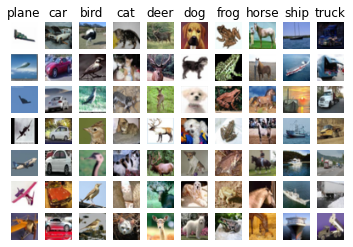

In [322]:
num_clases_knn = len(clases_knn)
samples_per_class = 7
for y, cls in enumerate(clases_knn):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_clases_knn + y + 1
        plt.subplot(samples_per_class, num_clases_knn, plt_idx)
        plt.imshow(x_trainknn[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Se importa el tipo de clasificador a utilizarse para el modelo.

In [253]:
from sklearn.neighbors import KNeighborsClassifier

Se remapean los arrays de entrenamiento y prueba, debido a la naturaleza propia del modelo, que requiere, las imágenes y las etiquetas en forma de arrays.

In [255]:
x_trainknn = x_trainknn.reshape(x_trainknn.shape[0],-1)
x_testknn = x_testknn.reshape(x_testknn.shape[0], -1)
print(x_trainknn.shape, y_trainknn.shape)
print(x_testknn.shape, y_testknn.shape)

(50000, 3072) (50000, 1)
(10000, 3072) (10000, 1)


Se entrena el modelo, utilizando como parámetro importante, la cantidad de vecinos que deberá buscar, así como el tipo de algoritmo que utilizará el cálculo.

In [293]:
clasificador = KNeighborsClassifier(n_neighbors=3, algorithm='brute').fit(x_trainknn, y_trainknn)

c:\Users\SIERRA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Se realizan predicciones con el modelo.

In [294]:
y_pred = clasificador.predict(x_testknn)

Se estima la cantidad de aciertos del modelo sobre el dataset de prueba.

In [295]:
num_correct = 0
for i in range(0, len(y_pred)):
  if(y_pred[i] == y_testknn[i]):
    num_correct+=1

Se estima la precisión del modelo en un 33%.

In [296]:
accuracy = float(num_correct) / len(y_pred)
print('Se obtivieron %d / %d aciertos => precisión: %f' % (num_correct, len(y_testknn), accuracy))

Se obtivieron 3303 / 10000 aciertos => precisión: 0.330300
